# Concreate Crack Image Using Transfer Learning


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, datetime

In [2]:

import tensorflow as tf
from keras import layers,optimizers,losses,callbacks,applications,models

## Dataset Preprocessed

In [3]:
import cv2
import imghdr

In [4]:
data_dir ='Dataset' #dir dataset
image_exts=['jpeg','jpg','bmp','png'] #ext for img file we want

for image_class in os.listdir(data_dir):       # open data
    for image in os.listdir(os.path.join(data_dir,image_class)): #open subfolder data/happy
        image_path=os.path.join(data_dir,image_class,image) #open file data/happy/img1.jpg
        try:
            img=cv2.imread(image_path)
            tip=imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not exts')
                os.remove(image_path)          # remove thing that not have mention ext
        except Exception as e:
            print("Cv2 read error {}".format(image_path))

## Load Data

In [8]:
# since we using tranfer learning 
data= tf.keras.utils.image_dataset_from_directory(data_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(227,227))
type(data)

Found 40000 files belonging to 2 classes.


tensorflow.python.data.ops.dataset_ops.BatchDataset

## Data Investigation

In [40]:
image,label=data.as_numpy_iterator().next()
print(len(image)) #check image per batch
print(image[:3].shape) # 3 image in first batch


32
(3, 227, 227, 3)


In [48]:
print((len(data))) #check how may batch

1250


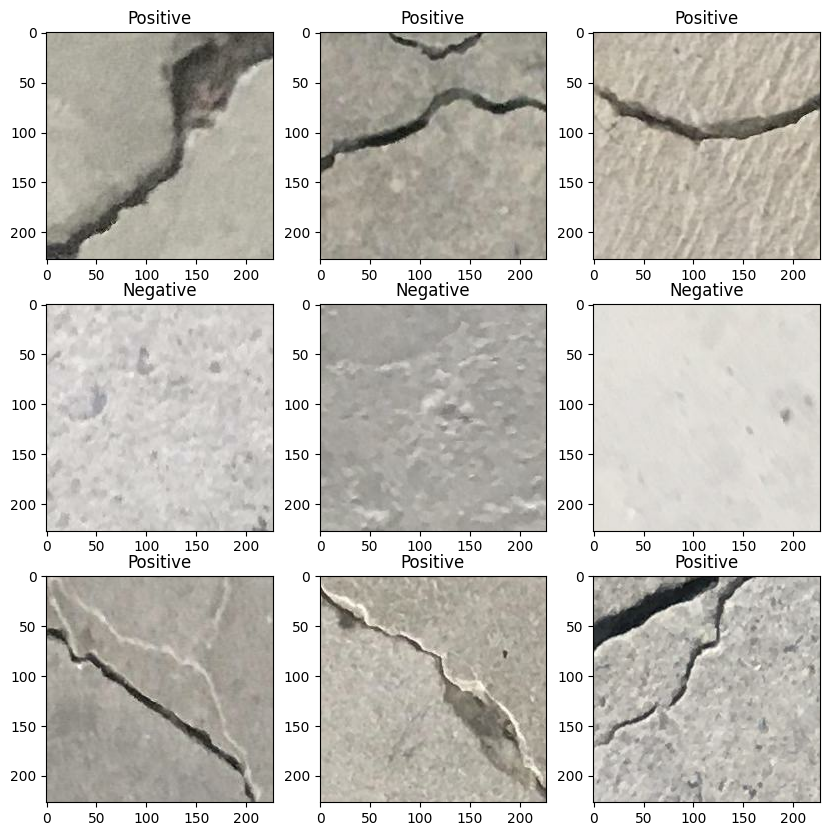

In [9]:
# Check the image with label look

class_names = data.class_names

plt.figure(figsize=(10, 10))
for images, labels in data:
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  #matplot expecting numpy and also change to 8bit(0-255)
    plt.title(class_names[labels[i]])
    

## Data Preparation


### Data splitting


In [56]:
# split the data to 70 20 10 , train val test respectively

train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

train_df = data.take(train_size)
val_df = data.skip(train_size).take(val_size)
test_df = data.skip(train_size + val_size)


In [57]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

875
250
125


### Prefetch 

In [62]:
train_df = train_df.prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.prefetch(buffer_size=tf.data.AUTOTUNE)


## Pipeline Development


### data augmentation


In [68]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

### Pretrained Model

In [69]:
#define the preprocess module for our pretrain model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [71]:
# A load pretrain model

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (227,227)+ (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # we just want featrues extration layer (False)
                                               weights='imagenet')
base_model.trainable=False # freeze the weight so the model overfit with new dataset
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 114, 114, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 114, 114, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Build pipeline with functional API

In [76]:
inputs=tf.keras.Input(shape=IMG_SHAPE)   
x=data_augmentation(inputs)                   #add data augmentation
x=preprocess_input(x)                         #normalize the data for mobilenetcv2 -1 1
x=base_model(x,training=False)                   #tranfer learning features extractor
x=tf.keras.layers.GlobalAveragePooling2D()(x)    #global average act like flatten layer for out classification layer
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(data.class_names))(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 227, 227, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 227, 227, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                           

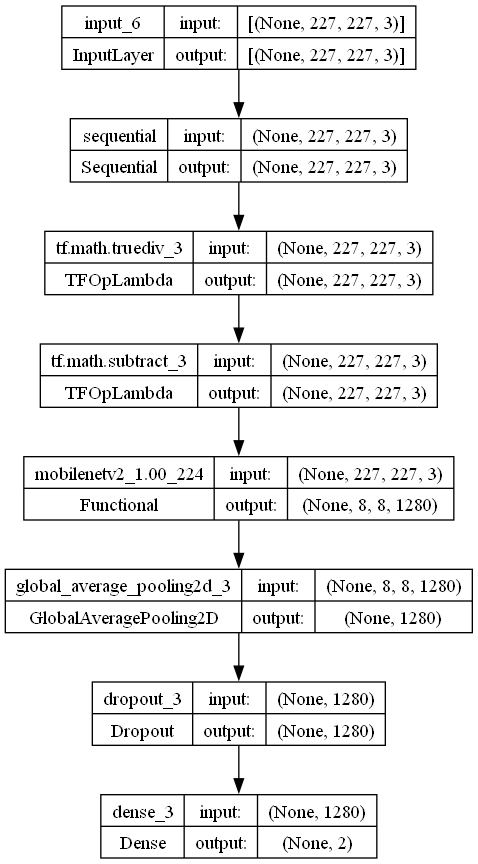

In [98]:
tf.keras.utils.plot_model(model, show_shapes=True) #plot the architecture

### Model Training

In [78]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

earlystoping=callbacks.EarlyStopping(patience=2)

PATH=os.getcwd()
logpath=os.path.join(PATH,'tensorboard_log',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb=callbacks.TensorBoard(logpath)

In [79]:
"""showing our transfer learning work bcs it give boost acc even not train yet"""
model.evaluate(test_df)      

125/125 [==============================] - 44s 278ms/step - loss: 1.1226 - accuracy: 0.2880


[1.1225800514221191, 0.2879999876022339]

In [80]:
history=model.fit(
    train_df,
    validation_data=val_df,
    epochs=10,
    callbacks=[earlystoping,tb]
)

Epoch 1/10
875/875 [==============================] - 355s 398ms/step - loss: 0.1414 - accuracy: 0.9491 - val_loss: 0.0295 - val_accuracy: 0.9951
Epoch 2/10
875/875 [==============================] - 345s 394ms/step - loss: 0.0235 - accuracy: 0.9946 - val_loss: 0.0164 - val_accuracy: 0.9962
Epoch 3/10
875/875 [==============================] - 343s 392ms/step - loss: 0.0166 - accuracy: 0.9955 - val_loss: 0.0125 - val_accuracy: 0.9964
Epoch 4/10
875/875 [==============================] - 350s 400ms/step - loss: 0.0119 - accuracy: 0.9965 - val_loss: 0.0106 - val_accuracy: 0.9970
Epoch 5/10
875/875 [==============================] - 347s 396ms/step - loss: 0.0112 - accuracy: 0.9965 - val_loss: 0.0091 - val_accuracy: 0.9971
Epoch 6/10
875/875 [==============================] - 345s 394ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0088 - val_accuracy: 0.9977
Epoch 7/10
875/875 [==============================] - 374s 427ms/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0079 -

### Model Perfomances

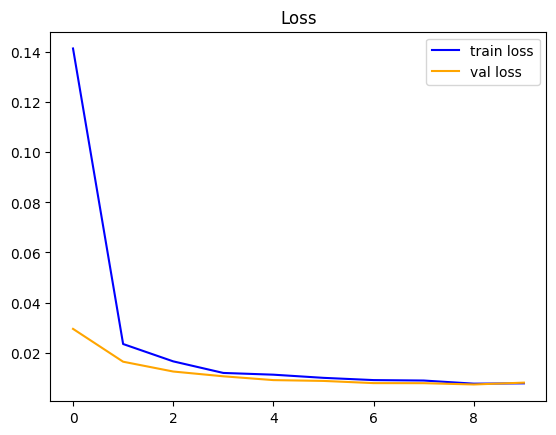

In [99]:
fig=plt.figure()
plt.plot(history.history['loss'],color='blue',label='train loss')
plt.plot(history.history['val_loss'],color='orange',label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

### Evaluate on test data

In [94]:
model.evaluate(test_df)
"""the result is very satisfied so we move to save model above 90% acc"""

125/125 [==============================] - 47s 315ms/step - loss: 0.0038 - accuracy: 0.9990


[0.00381256896071136, 0.9990000128746033]

### Save Model

In [86]:
model_save_path = os.path.join(PATH, 'saved_model', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(model_save_path, exist_ok=True) # Create dir if not created yet

# Save the model as .h5
model.save(os.path.join(model_save_path, 'model.h5'))

## Model Deployment

In [95]:
image_batch, label_batch = test_df.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions_index=np.argmax(predictions,axis=1) #get the highest propabilites

In [96]:
label_map={i:names for i,names in enumerate(data.class_names)} # arrange label with index

predictions_list=[label_map[i] for i in predictions_index] # prediction with the class name instead

label_list=[label_map[i] for i in label_batch] # label with the class name instead

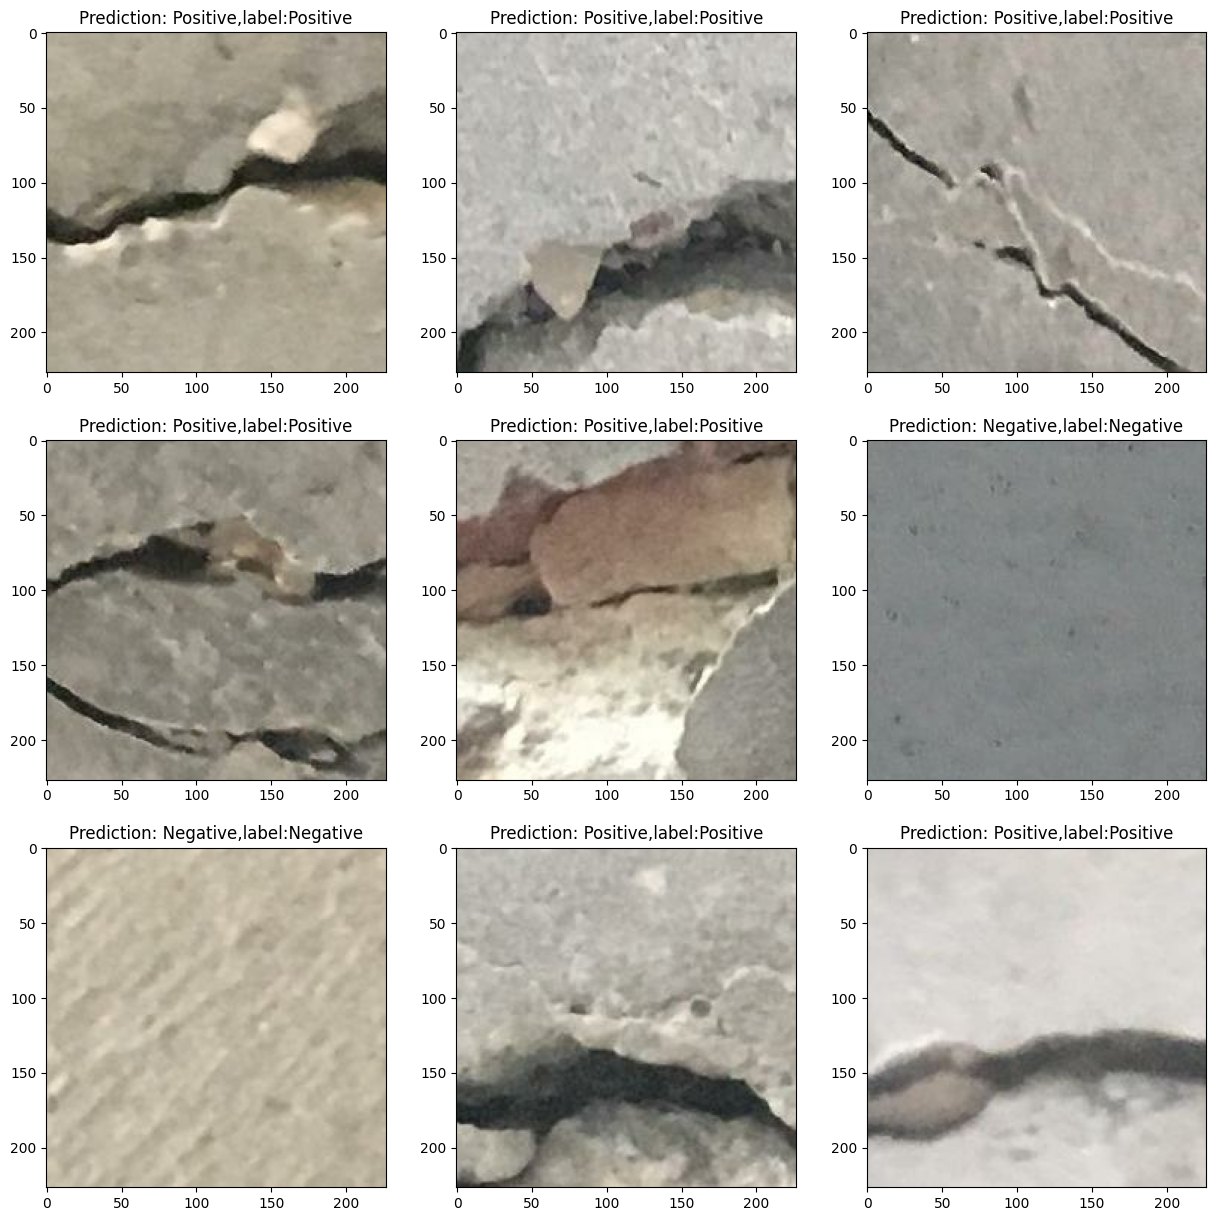

In [97]:
plt.figure(figsize=(15,15))
for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Prediction: {predictions_list[i]},label:{label_list[i]}") # displaying predict and label side by side